## Wikidata Knowledge Graph Extraction
Many recommendation algorithms (DKN, RippleNet, KGCN) use Knowledge Graphs as an external source of information. We found that one of the bottlenecks to benchmark current algorithms like DKN, RippleNet or KGCN is that they used Microsoft Satori. As Satori is not open source, it's not possible to replicate the results found in the papers. The solution is using other open source KGs.

The goal of this notebook is to provide examples of how to interact with Wikipedia queries and Wikidata to extract a Knowledge Graph that can be used with the mentioned algorithms.

The steps covered are:
- How to find a Wikidata entity (https://www.wikidata.org/wiki/Wikidata:Glossary/en from a text query
- How to find surrounding entities and descriptions for an entity
- Create a KG for Movielens

In [1]:
# set the environment path to find Recommenders
import sys
sys.path.append("../../")
print("System version: {}".format(sys.version))

import pandas as pd
from reco_utils.dataset.wikidata import (search_wikidata, 
                                         find_wikidata_id, 
                                         query_entity_links, 
                                         read_linked_entities,
                                         query_entity_description)

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from reco_utils.dataset import movielens
from reco_utils.common.notebook_utils import is_jupyter

System version: 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'
MOVIELENS_SAMPLE = True
MOVIELENS_SAMPLE_SIZE = 50

## 1. Create a KG from linked entities in Wikidata

In [3]:
names = ["The Godfather", "Al Pacino", "Tom Hanks", "Forrest Gump", "Julia Roberts", "", "My Best Friend's Wedding"]

In [7]:
%%time

# the following code has been wrapped in a helper function called search_wikidata()
# it is provided here to show the details of which calls are being made to wikipedia APIs

# capture results as a list of dicts to transform to DataFrame (this is faster than appending to DataFrames)
results_list = []
for idx, name in enumerate(names):
    # first get the wikipedia entity_id for each name
    entity_id = find_wikidata_id(name)
    if entity_id == "entityNotFound":
        continue

    # next we query wikipedia to get entity links
    json_links = query_entity_links(entity_id)

    # the following function extracts entities from the links
    related_links = read_linked_entities(json_links)

    # now we can construct an connection in our graph between two entities
    for related_entity, related_name in related_links:
        result = dict(
            name=name,
            original_entity=entity_id,
            linked_entities=related_entity,
            name_linked_entities=related_name,
        )
        results_list.append(result)

results_list = pd.DataFrame(results)
results_list.head()

Wall time: 1.95 s


,name,original_entity,linked_entities,name_linked_entities
0,Al Pacino,Q41163,Q10798782,television actor
1,Al Pacino,Q41163,Q10800557,film actor
2,Al Pacino,Q41163,Q2259451,stage actor
3,Al Pacino,Q41163,Q2526255,film director
4,Al Pacino,Q41163,Q3282637,film producer


### Visualize KG using networkx

In [8]:
G = nx.from_pandas_edgelist(results_list, 'original_entity', 'linked_entities')

In [9]:
target_names = results_list[["linked_entities", "name_linked_entities"]].drop_duplicates().rename(columns={"linked_entities": "labels", "name_linked_entities": "name"})
source_names = results_list[["original_entity", "name"]].drop_duplicates().rename(columns={"original_entity": "labels"})
names = pd.concat([target_names, source_names])
names = names.set_index("labels")
names = names.to_dict()["name"]

C:\Users\scgraham\AppData\Local\Continuum\anaconda3\envs\reco_base\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


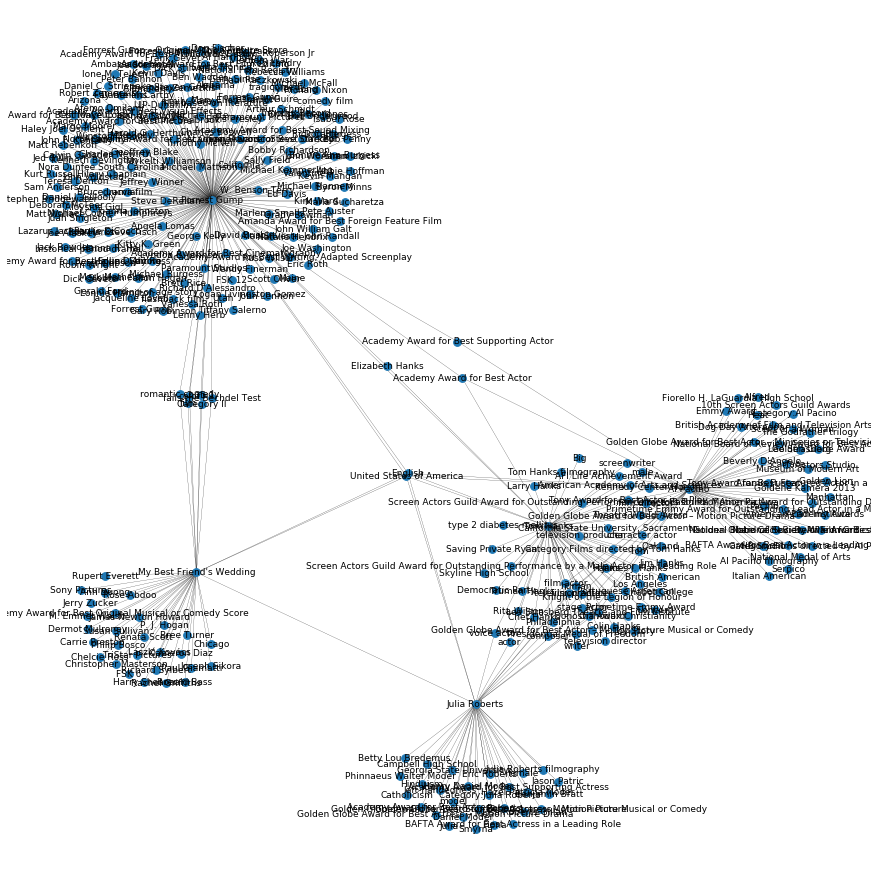

In [10]:
plt.figure(figsize=(12,12)) 
pos = nx.spring_layout(G)
nx.draw(G,pos, node_size=60,font_size=9, width = 0.2)
nx.draw_networkx_labels(G, pos, names, font_size=9)
plt.show()

## 2. Create a KG from the Movielens Dataset

In [11]:
# Obtain pairs of Movie Title - IDs from Movielens
df = movielens.load_pandas_df(MOVIELENS_DATA_SIZE,
                              ('UserId', 'ItemId', 'Rating', 'Timestamp'),
                             title_col='Title',
                             genres_col='Genres',
                             year_col='Year'
        )
movies = df[["Title", "ItemId"]].drop_duplicates().reset_index()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.81k/4.81k [00:01<00:00, 2.80kKB/s]


In [12]:
movies["Title"][0:5]

0                  Kolya (1996)
1      L.A. Confidential (1997)
2           Heavyweights (1994)
3    Legends of the Fall (1994)
4           Jackie Brown (1997)
Name: Title, dtype: object

In [13]:
# For notebook testing
if MOVIELENS_SAMPLE == True:
    movies = movies.head(MOVIELENS_SAMPLE_SIZE)

In [14]:
movies.shape

(50, 3)

In [15]:
names = [t + ' film' for t in movies['Title']]
result = search_wikidata(names, extras=movies[['Title', 'ItemId']].to_dict())
result.head()

,name,original_entity,linked_entities,name_linked_entities,description,Title,ItemId
0,Kolya (1996) film,Q1141186,Q130232,drama film,1996 film by Jan Svěrák,Kolya (1996),242
1,Kolya (1996) film,Q1141186,Q157443,comedy film,1996 film by Jan Svěrák,Kolya (1996),242
2,Kolya (1996) film,Q1141186,Q10819887,Andrei Chalimon,1996 film by Jan Svěrák,Kolya (1996),242
3,Kolya (1996) film,Q1141186,Q11775055,René Přibil,1996 film by Jan Svěrák,Kolya (1996),242
4,Kolya (1996) film,Q1141186,Q12035276,Marek Daniel,1996 film by Jan Svěrák,Kolya (1996),242


In [16]:
result["Title"].value_counts()

Silence of the Lambs, The (1991)                           111
L.A. Confidential (1997)                                    70
Kolya (1996)                                                67
Remains of the Day, The (1993)                              51
Jackie Brown (1997)                                         51
Sleepless in Seattle (1993)                                 46
Legends of the Fall (1994)                                  45
Jungle Book, The (1994)                                     45
Rear Window (1954)                                          45
Only You (1994)                                             42
Heavyweights (1994)                                         42
Broken Arrow (1996)                                         42
Just Cause (1995)                                           40
Kiss the Girls (1997)                                       38
To Wong Foo, Thanks for Everything! Julie Newmar (1995)     38
Restoration (1995)                                     

In [17]:
# result.to_csv("movielens_" + MOVIELENS_DATA_SIZE + '_wikidata.csv', index = False)

In [18]:
number_movies = len(result["Title"].unique())

In [16]:
# Record results with papermill for tests - ignore this cell
if is_jupyter():
    # Record results with papermill for unit-tests
    import papermill as pm
    pm.record("length_result", number_movies)